In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Final_Project/Train_dataset_new.zip" -d "/content/drive/MyDrive/Final_Project/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000001.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000002.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000003.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000004.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000005.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000006.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000007.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000008.jpg  
  inflating: /content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/railroad_track/00000009.j

In [3]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as  np
from torchvision import utils
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
path='/content/drive/MyDrive/Final_Project/dataset/Train_dataset_new'
n_channels = 3
n_classes = 15
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # using ImageNet's mean and std deviation
])

In [25]:
dataset = datasets.ImageFolder(root=path, transform=transform)
# Split the dataset into train, test and validation.
print(len(dataset))

73607


In [26]:
total_dataset_len = len(dataset)
train_dataset_len = int(0.7 * total_dataset_len)
val_dataset_len = int(0.15 * total_dataset_len)
test_dataset_len = total_dataset_len - train_dataset_len - val_dataset_len
# print(train_dataset_len, val_dataset_len, test_dataset_len,  train_dataset_len + val_dataset_len + test_dataset_len )
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_dataset_len, val_dataset_len, test_dataset_len])

In [27]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=4, shuffle=False)
print(len(train_loader))

806


In [28]:
def show_data(img_grid):
    plt.figure(figsize=(10,10))
    image = img_grid/2 + 0.485
    # image = img_grid/2
    image_np = image.numpy()
    image_T = np.transpose(image_np, (1, 2, 0)) # Convert (C, H, W) to (H, W, C)
    plt.imshow(image_T)
    plt.show()

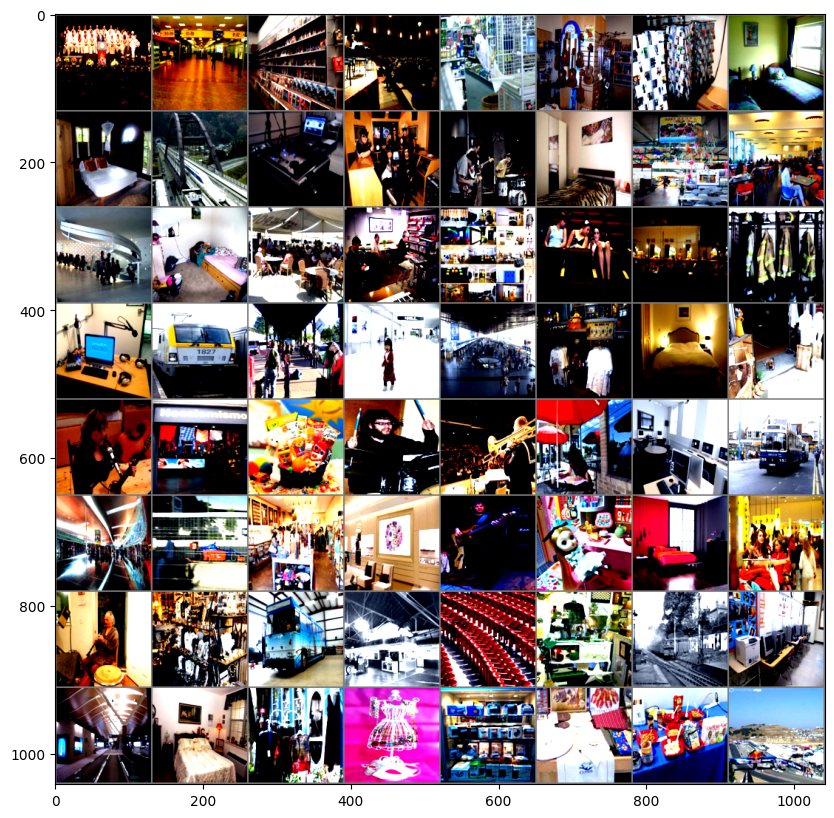

auditorium airport_terminal bookstore auditorium pet_shop gift_shop gift_shop bedroom bedroom railroad_track computer_room music_studio music_studio bedroom food_court food_court airport_terminal bedroom food_court music_studio clothing_store auditorium food_court clothing_store music_studio railroad_track bus_station-indoor airport_terminal airport_terminal clothing_store bedroom clothing_store music_studio clothing_store pet_shop music_studio auditorium coffee_shop computer_room bus_station-indoor airport_terminal raceway clothing_store jewelry_shop music_studio pet_shop bedroom food_court music_studio jewelry_shop bus_station-indoor airport_terminal auditorium gift_shop railroad_track computer_room airport_terminal bedroom clothing_store jewelry_shop pet_shop gift_shop pet_shop raceway


In [29]:
from torchvision import utils
import matplotlib.pyplot as plt


# Create the iterator for the image
image_load_iter = iter(train_loader)
images, labels = next(image_load_iter)

img_grid = utils.make_grid(images)
show_data(img_grid)

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(64)))
# Referred from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [41]:
import torch
import torch.nn as nn

class VGG11_custom(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(VGG11_custom, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        img = self.relu(self.conv1(x))
        img = self.pool(img)
        img = self.relu(self.conv2(img))
        img = self.pool(img)
        img = self.relu(self.conv3(img))
        img = self.relu(self.conv4(img))
        img = self.pool(img)
        img = self.relu(self.conv5(img))
        img = self.relu(self.conv6(img))
        img = self.pool(img)
        img = self.relu(self.conv7(img))
        img = self.relu(self.conv8(img))
        img = self.pool(img)
        img = torch.flatten(img, 1)
        img = self.relu(self.fc1(img))
        img = self.dropout(img)
        img = self.relu(self.fc2(img))
        img = self.dropout(img)
        img = self.fc3(img)
        # img = self.softmax(img)
        return img

In [42]:
import torch.optim as optim
model = VGG11_custom(n_channels, n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
model = model.to(device)
# Reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [43]:
def eval_model(model, data_loader, type='validation'):
  correct=0
  total=0
  running_loss = 0.0
  with torch.no_grad():
    model.eval()
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      pred = model(inputs)
      total += labels.size(0)
      loss = criterion(pred, labels.squeeze().long())
      running_loss += loss.item()
      _, predicted = torch.max(pred.data, 1)
      correct += predicted.eq(labels.squeeze().long()).sum().item()
  test_val_loss = running_loss / len(data_loader)
  test_val_accuracy = 100 * correct / total
  return test_val_loss, test_val_accuracy

In [44]:
n_epochs = 20
running_loss = 0.0
training_loss_arr = []
training_accuracy_arr = []
validation_accuracy_arr = []
validation_loss_arr = []
test_accuracy_arr = []
test_loss_arr = []

for epoch in range(n_epochs):
  model.train()
  train_correct = 0
  train_total = 0
  running_loss = 0.0
  i = 0
  for (images, labels) in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    pred = model(images)
    optimizer.zero_grad()
    loss = criterion(pred, labels.squeeze().long())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = torch.max(pred.data, 1)
    train_total += labels.size(0)
    train_correct += predicted.eq(labels.squeeze().long()).sum().item()
    i += 1
    if i % 50 == 0:
      print(f'Epoch {epoch + 1}/{n_epochs},  loss single {loss.item()}')

  training_accuracy = (train_correct / train_total)*100
  training_loss = running_loss / len(train_loader)
  training_loss_arr.append(training_loss)
  training_accuracy_arr.append(training_accuracy)
  validation_loss, validation_accuracy = eval_model(model, val_loader, type='validation')
  validation_loss_arr.append(validation_loss)
  validation_accuracy_arr.append(validation_accuracy)
  test_loss, test_accuracy = eval_model(model, test_loader, type='testing')
  test_accuracy_arr.append(test_accuracy)
  test_loss_arr.append(test_loss)
  #scheduler.step()
  print(f'Epoch {epoch + 1}, Training Accuracy: {training_accuracy:.2f} %')
  print(f'Epoch {epoch + 1}, Training Loss: {training_loss:.2f}')
  print(f'Epoch {epoch + 1}, Validation Accuracy: {validation_accuracy:.2f} %')
  print(f'Epoch {epoch + 1}, Validation Loss: {validation_loss:.2f}')
  print(f'Epoch {epoch + 1}, Test Accuracy: {test_accuracy:.2f} %')
  print(f'Epoch {epoch + 1}, Test Loss: {test_loss:.2f}')

Epoch 1/20,  loss single 93.40753936767578
Epoch 1/20,  loss single 2.77286696434021
Epoch 1/20,  loss single 2.6696698665618896
Epoch 1/20,  loss single 2.714359760284424
Epoch 1/20,  loss single 2.7070465087890625
Epoch 1/20,  loss single 2.694117546081543


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 419, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 419, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 284, in default_loader
    return pil_loader(path)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 263, in pil_loader
    img = Image.open(f)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Final_Project/dataset/Train_dataset_new/bus_station-indoor/00003225.jpg'>


In [33]:
# Printing the metrics
print(f'Training Accuracy: {training_accuracy:.2f} % ')
print(f'Training Loss: {training_loss:.2f}')
print(f'Validation Accuracy: {validation_accuracy:.2f} %')
print(f'Validation Loss: {validation_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f} %')
print(f'Test Loss: {test_loss:.2f}')

Training Accuracy: 6.74 % 
Training Loss: 2.71
Validation Accuracy: 6.92 %
Validation Loss: 2.71
Test Accuracy: 6.53 %
Test Loss: 2.71


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
import seaborn as sns

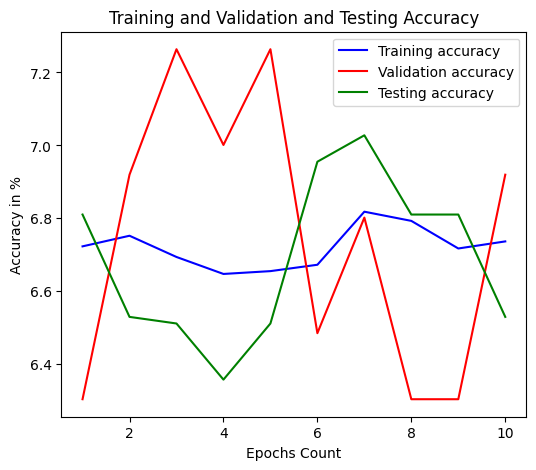

In [35]:
# Plot the training and validation accuracy over time (epochs)
num_of_epochs = range(1, len(training_loss_arr) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, training_accuracy_arr, 'b', label='Training accuracy')
plt.plot(num_of_epochs, validation_accuracy_arr, 'r', label='Validation accuracy')
plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

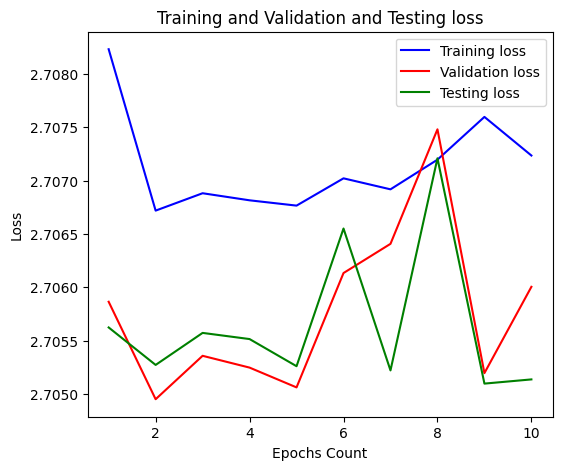

In [36]:
# Plot the training, validation and testing loss over time (epochs)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, training_loss_arr, 'b', label='Training loss')
plt.plot(num_of_epochs, validation_loss_arr, 'r', label='Validation loss')
plt.plot(num_of_epochs, test_loss_arr, 'g', label='Testing loss')
plt.title('Training and Validation and Testing loss')
plt.xlabel('Epochs Count')
plt.ylabel('Loss')
plt.legend()
plt.show()